In [10]:
import pandas as pd
import numpy as np

malpractice = pd.read_csv("medicalMalpractice.csv")

First, I'm going to do some EDA on the dataset

In [3]:
print(malpractice['Amount'].describe())
print(malpractice['Age'].value_counts())
print(malpractice['Gender'].value_counts())
print(malpractice['Insurance'].value_counts())
print(malpractice['Marital Status'].value_counts())
print(malpractice['Private Attorney'].value_counts())
print(malpractice['Severity'].value_counts())
print(malpractice['Specialty'].value_counts())


count     79210.000000
mean     157484.554816
std      193135.093293
min        1576.000000
25%       43670.250000
50%       98131.000000
75%      154675.250000
max      926411.000000
Name: Amount, dtype: float64
Age
43    1439
48    1418
47    1405
50    1395
44    1389
      ... 
84     142
85     134
86     121
1       97
0       89
Name: count, Length: 88, dtype: int64
Gender
Female    47770
Male      31440
Name: count, dtype: int64
Insurance
Private                 34289
Unknown                 24052
Medicare/Medicaid       10882
No Insurance             8002
Workers Compensation     1985
Name: count, dtype: int64
Marital Status
2    41220
1    22802
4    10362
0     3832
3      994
Name: count, dtype: int64
Private Attorney
1    52349
0    26861
Name: count, dtype: int64
Severity
3    28251
4    15709
5     9615
7     8873
9     7755
8     3627
6     3375
2     1340
1      665
Name: count, dtype: int64
Specialty
Family Practice           11436
General Surgery            9412
OBGY

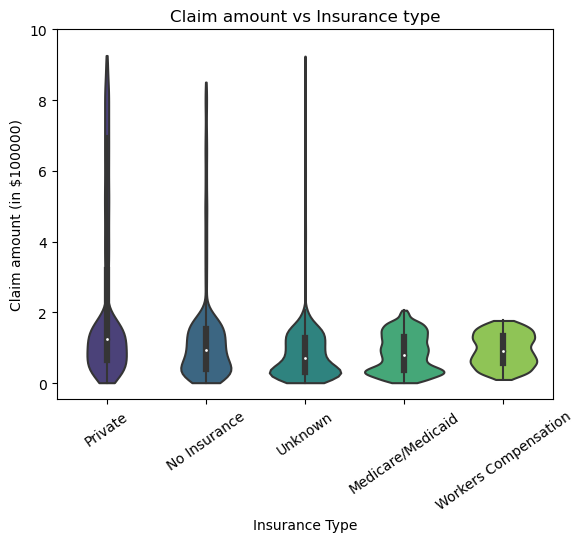

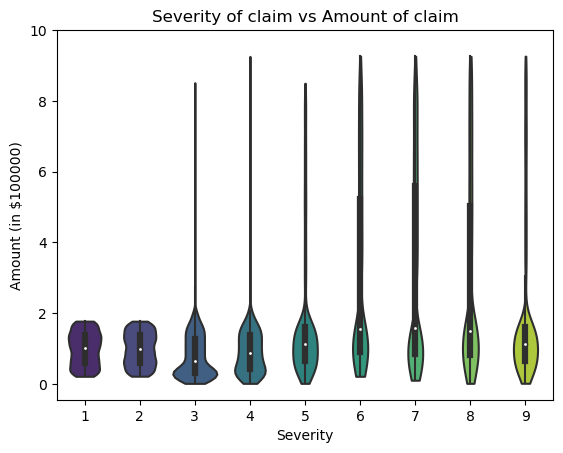

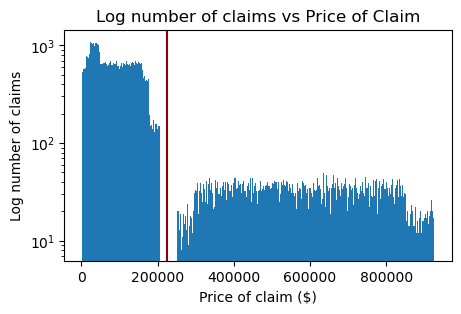

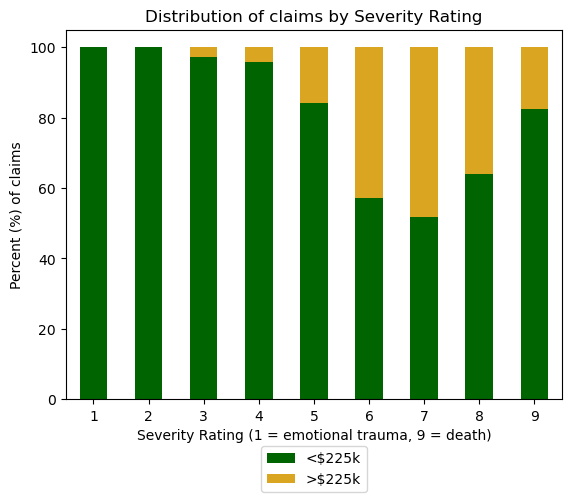

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns



sns.violinplot(data = malpractice, x = "Insurance",y = "Amount", cut =0, palette='viridis')
plt.xticks(rotation = 35)
plt.yticks([0.,  200000.,  400000.,  600000.,  800000.,
        1000000.], [0, 2, 4, 6, 8, 10])
plt.title("Claim amount vs Insurance type")
plt.xlabel("Insurance Type")
plt.ylabel("Claim amount (in $100000)")
plt.show()

sns.violinplot(data = malpractice, x = "Severity", y = "Amount", cut = 0, palette='viridis')
plt.yticks([0.,  200000.,  400000.,  600000.,  800000.,
       1000000.], [0, 2, 4, 6, 8, 10])
plt.title("Severity of claim vs Amount of claim")
plt.ylabel("Amount (in $100000)")
plt.show()

plt.figure(figsize=(5, 3))
plt.hist((malpractice['Amount']), bins = 500, log=True)
plt.title("Log number of claims vs Price of Claim")
plt.xlabel("Price of claim ($)")
plt.ylabel("Log number of claims")
plt.axvline(x = 225000, color = 'darkred', label = 'axvline - full height')
plt.show()

#Creating a bar plot showing the percent of each severity that has an amount greater than 250k

malpractice['Below225000'] = (malpractice['Amount'] <= 225000)
severity_graph = pd.DataFrame(malpractice.groupby('Severity')['Below225000'].agg('mean'))
severity_graph.reset_index(inplace=True)
severity_graph['Above225000'] = 1 - severity_graph['Below225000']
severity_graph.set_index('Severity',inplace=True)
severity_graph.plot(kind = "bar", stacked=True, color = ['darkgreen', "goldenrod"])
plt.title("Distribution of claims by Severity Rating")
plt.xlabel("Severity Rating (1 = emotional trauma, 9 = death)")
plt.ylabel("Percent (%) of claims")
plt.xticks(rotation = 0)
plt.yticks([0. , 0.2, 0.4, 0.6, 0.8, 1.], [0, 20, 40, 60, 80, 100])
plt.legend(bbox_to_anchor =(0.5,-0.27), loc='lower center', labels = ['<$225k', '>$225k'])
plt.show()

## Notes from EDA

Insurance and Marital Status both have missing values 

Amount is bimodal, with most between 0 and 200k but then some others having suits from 200k to 900k

Two different theoretical projects:
1. Predicting suit price by regression
2. Predicting whether a suit will be for more than 200k by classification

Now, I'm dealing with some of the errors I found during EDA:
- Changing marital status and private attorney from numbers to words describing the status
- Changing "unknown" to np.NaN so I can work with missing values

In [12]:
malpractice.loc[malpractice['Insurance'] == "Unknown", "Insurance"] = np.NaN
malpractice.loc[malpractice['Marital Status'] == 0, "Marital Status"] = "Divorced"
malpractice.loc[malpractice['Marital Status'] == 1, "Marital Status"] = "Single"
malpractice.loc[malpractice['Marital Status'] == 2, "Marital Status"] = "Married"
malpractice.loc[malpractice['Marital Status'] == 3, "Marital Status"] = "Widowed"
malpractice.loc[malpractice['Marital Status'] == 4, "Marital Status"] = np.NaN
malpractice.loc[malpractice['Private Attorney'] == 0, "Private Attorney"] = "Not Private"
malpractice.loc[malpractice['Private Attorney'] == 1, "Private Attorney"] = "Private"


In [6]:
print(np.mean(pd.isna(malpractice['Marital Status'])))
print(np.mean(pd.isna(malpractice['Insurance'])))
print(malpractice.isnull().any(axis = 'columns').mean())

0.13081681605857845
0.3036485292261078
0.3787779320792829


Now, I'm going to split up the data. I want to guess whether a medical malpractice suit is going to cost more or less than $250k

In [7]:
from sklearn.model_selection import train_test_split
random_state = 42

X = malpractice.drop(columns=['Amount', 'Below225000'])
y = malpractice['Amount'].copy()
y[y <= 250000] = 0
y[y > 250000] = 1

X_train, X_other, y_train, y_other = train_test_split(X, y, train_size = 0.6, stratify=y, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, stratify=y_other, random_state=random_state)

print(np.mean(y_train == 1))
print(np.mean(y_val == 1))
print(np.mean(y_test == 1))

0.14381601649623363
0.14385809872490848
0.14379497538189623


Preprocessing Data

In [30]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 

one_hot_fts = ['Private Attorney', 'Marital Status', 'Specialty', 'Insurance', 'Gender']

std_fts = ['Age']

transforms = ColumnTransformer([
        ('cat', OneHotEncoder(), one_hot_fts), 
        ('std', StandardScaler(), std_fts)])

pipe = Pipeline([
    ("transforms", transforms)])

X_train_prep = pipe.fit_transform(X_train)
X_val_prep = pipe.transform(X_val)
X_test_prep = pipe.transform(X_test)



In [36]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Helps the submodel, by working on a singular model
def Submodel_Helper(X_train, y_train, X_CV, y_CV, X_test, y_test, model, param_grid):
    
    pass

def Submodel(X, y, model, preprocessor : Pipeline, param_grid : dict, state):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=state)
    X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, stratify=y_other, random_state=state)
    
    
    #Preprocessing data 
    transformed_train = preprocessor.fit_transform(X_train)
    transformed_cv = preprocessor.transform(X_CV)
    transformed_test = preprocessor.transform(X_test)
    colnames = preprocessor.get_feature_names_out()
    print(colnames.shape)
    print(transformed_train.shape)
    print(preprocessor)
    
    df_train = pd.DataFrame(data = transformed_train, columns=colnames)
    df_cv = pd.DataFrame(data = preprocessor.transform(X_CV), columns=preprocessor.get_feature_names_out())
    df_test = pd.DataFrame(data = preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

    

def StratKFoldModel(X, y, model, preprocessor, param_grid, submodel = False):
    #-- Creates a function that takes in the data, a model, a preprocessor, and a parameter grid
    #And throws out the scores and best models
    test_scores = []
    best_models = []
    for state in np.linspace(0, 9, dtype=int):
        #XGBoost can handle NAs, so we don't need to use any pa for XGBoost
        if submodel:
            pass
        else:
            pipe = make_pipeline(preprocessor, model)

        #stratified train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state, stratify=y)
        print(X_train)
        kf = StratifiedKFold(random_state=state, shuffle=True)
        #Creating a GridSearchCV
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring = f1_score, cv = kf, error_score='raise')
        grid.fit(X_train, y_train)
        y_preds = grid.predict(X_test)
        test_scores.append(f1_score(y_test, y_preds))
        best_models.append(grid.best_estimator_)

    return test_scores, best_models



In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost

one_hot_fts = ['Private Attorney', 'Marital Status', 'Specialty', 'Insurance', 'Gender']

std_fts = ['Age']

preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(), one_hot_fts), 
        ('std', StandardScaler(), std_fts)])



XGB Model, which is done separately from the rest

In [43]:
import xgboost
from sklearn.metrics import f1_score

test_scores = []
best_models = []
for state in np.linspace(0, 9, dtype = int):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=state)
    
    #list of parameters to loop through for XGBoost
    param_dict = {
        'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
        'xgbclassifier__max_depth': [3, 4, 5, 6, 7],
        'xgbclassifier__n_estimators': [25, 50, 75],
        'xgbclassifier__gamma': [0.01, 0.1, 0.2]
    }

    xgb = xgboost.XGBClassifier()
    cv = StratifiedKFold(n_splits=4)
    pipeline = make_pipeline(preprocessor, xgb)
    grid = GridSearchCV(pipeline, param_grid = param_dict, scoring = 'f1', cv = cv, verbose = 2, n_jobs=-1)

    grid.fit(X_train, y_train)
    y_preds = grid.predict(X_test)
    test_scores.append(f1_score(y_test, y_preds))
    best_models.append(grid.best_estimator_)

print(f"The average test f1 score is {np.mean(test_scores)}")


Fitting 4 folds for each of 135 candidates, totalling 540 fits
[CV] END xgbclassifier__gamma=0.01, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=25; total time=   1.8s
[CV] END xgbclassifier__gamma=0.01, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=25; total time=   1.9s
[CV] END xgbclassifier__gamma=0.01, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=25; total time=   1.8s
[CV] END xgbclassifier__gamma=0.01, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=25; total time=   1.8s
[CV] END xgbclassifier__gamma=0.01, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50; total time=   3.2s
[CV] END xgbclassifier__gamma=0.01, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50; total time=   3.1s
[CV] END xgbclassifier__gamma=0.01, x

In [36]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost

one_hot_fts = ['Private Attorney', 'Marital Status', 'Specialty', 'Insurance', 'Gender']

std_fts = ['Age']

preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(), one_hot_fts), 
        ('std', StandardScaler(), std_fts)])

xgb = xgboost.XGBClassifier()
xgb_params = {
        "logisticregression__penalty": ["elasticnet"], 
        "logisticregression__C": np.logspace(-3, 3, 7),
        "logisticregression__l1_ratio": np.linspace(0, 1, 5)        
}

#

logreg_results = StratKFoldModel(X, y, xgb, preprocessor=preprocessor, param_grid=xgb_params, submodel = False)



       Severity  Age Private Attorney Marital Status        Specialty  \
9164          4   46      Not Private         Single            OBGYN   
24709         4   40      Not Private        Married   Anesthesiology   
59493         5    7      Not Private         Single            OBGYN   
29520         3   29          Private        Married  Family Practice   
57262         7   35          Private        Married            OBGYN   
...         ...  ...              ...            ...              ...   
26885         5   44          Private         Single  Family Practice   
68947         3   57          Private        Married            OBGYN   
54622         7   38          Private        Married  Family Practice   
68314         6   17          Private         Single            OBGYN   
14025         7   29          Private        Married       Cardiology   

               Insurance  Gender  
9164   Medicare/Medicaid  Female  
24709                NaN  Female  
59493            P

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.